In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import os

import gsw
#import gsw_xarray as gsw # Wrapper for gsw that adds CF attributes
from wmt_inert_tracer.preprocessing import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

Schmidtko et al. (2014): 
**ASBW** is defined using the deepest measurement in profiles within *30 m* of the bottom, or, in the absence of CTD altimeter data, within 150m of the ETOPO-1 bathymetry. **ASBW** data are mapped onto a 0.25$^{\circ}\times$0.125$^{\circ}$ grid for bathymetry shallower than *1500 m*.

In [2]:
deptho_max = 1500
north = -60.0

In [3]:
outdir='/work/jet/data/interim/'

# Odiv-255, 293, 313
rootdir = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/'
# Odiv-233, 232, 231, 230, 306
#rootdir = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/'
# Odiv-226, Odiv-210, Odiv-209, Odiv-207, Odiv-206, Odiv-200, Odiv-191, Odiv-184
#rootdir = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/' 
#rootdir = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/' # Odiv-183, Odiv-170

subdir = 'CM4_piControl_c192_OM4p125_v8' # odiv-313
#subdir = 'CM4_ssp585_c192_OM4p125' # odiv-293
#subdir = 'CM4_historical_c192_OM4p125' # odiv-233/odiv-255
#subdir = 'CM4_ssp585_c192_OM4p25' # odiv-232
#subdir = 'CM4_historical_c192_OM4p25' # Odiv-231
#subdir = 'CM4_piControl_c192_OM4p25_v8' # odiv-230/odiv-306
#subdir = 'CM4_piControl_c192_OM4p25_v7_npolefix' # Odiv-226
#subdir = 'CM4_piControl_c192_OM4p25_v7' # Odiv-210
#subdir = 'CM4_piControl_c192_OM4p125_v7' # Odiv-209
#subdir = 'CM4_piControl_c192_OM4p125_v6_alt3' # Odiv-207
#subdir = 'CM4_piControl_c192_OM4p125_v6_alt2' # Odiv-206
#subdir = 'CM4_piControl_c192_OM4p125_v6_alt1' # Odiv-200
#subdir = 'CM4_piControl_c192_OM4p125_v6' # Odiv-191
#subdir = 'CM4_piControl_c192_OM4p125_v5' # Odiv-184
#subdir = 'CM4_piControl_c192_OM4p125_v5_proto1' # Odiv-183
#subdir = 'CM4_piControl_c192_OM4p25' # Odiv-170

#platform = 'gfdl.ncrc4-intel18-prod-openmp'
#platform = 'gfdl.ncrc4-intel22-prod-openmp' # odiv-306
platform = 'gfdl.ncrc5-intel22-prod-openmp' # odiv-255, 293, 313

In [4]:
pp = 'ocean_annual_z'
full_path = os.path.join(rootdir,subdir,platform,'pp',pp)+'/ts/annual/10yr/'

In [5]:
var = 'so'
tprd = '*'
print(full_path+pp+'.%s.%s.nc'%(tprd,var))

/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_piControl_c192_OM4p125_v8/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/ocean_annual_z.*.so.nc


In [6]:
vars_ds = xr.open_mfdataset(full_path+pp+'.%s.%s.nc'%(tprd,var),use_cftime=True, drop_variables=['average_DT','average_T1','average_T2'])
grid_ds = xr.open_dataset(os.path.join(rootdir,subdir,platform,'pp',pp)+'/'+pp+'.static.nc')

In [7]:
pd.concat([vars_ds.xh.to_series().reset_index(drop=True), #vars_ds.xq.to_series().reset_index(drop=True),
           grid_ds.xh.to_series().reset_index(drop=True), grid_ds.xq.to_series().reset_index(drop=True)], axis=1)

,xh,xh,xq
0,-298.604803,-298.604803,-298.533319
1,-298.488439,-298.488439,-298.417040
2,-298.372071,-298.372071,-298.300755
3,-298.255697,-298.255697,-298.184466
4,-298.139319,-298.139319,-298.068172
...,...,...,...
2876,60.929793,60.929793,61.001614
2877,61.046136,61.046136,61.117873
2878,61.162485,61.162485,61.234138
2879,61.278839,61.278839,61.350407


In [8]:
grid_ds = grid_ds.isel(xq=slice(None,-1),yq=slice(None,-1)) # p125
#grid_ds = grid_ds.isel(xq=slice(1,None),yq=slice(1,None)) # p25

In [9]:
ds = preprocessing(vars_ds, grid_ds, decode_times=False, verbose=False)

In [10]:
teos10=True # to calculate absolute salinity

In [11]:
if teos10:
    print('Calculate TEOS-10 Absolute salinity')
    p = xr.apply_ufunc(gsw.p_from_z, -ds['lev'], ds['lat'], 0, 0, dask='parallelized')
    sa = xr.apply_ufunc(gsw.SA_from_SP, ds.so, p, ds['lon'], ds['lat'], dask='parallelized')
    sab = sa.chunk({'time':1}).ffill('lev').isel(lev=-1).where(ds.lat<north).where(ds.deptho<deptho_max).rename(var)
else:
    sab = ds[var].chunk({'time':1}).ffill('lev').isel(lev=-1).where(ds.lat<north).where(ds.deptho<deptho_max)

Calculate TEOS-10 Absolute salinity


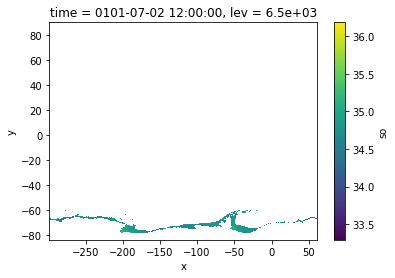

In [12]:
sab[0].plot()

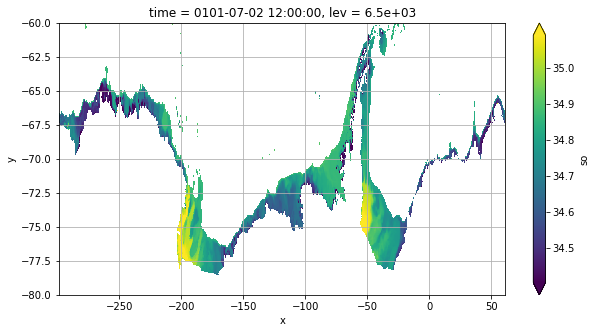

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
sab[0].where(ds.wet==1).plot(ax=ax,x='x',y='y',robust=True)
ax.set_ylim([-80, -60])
ax.grid(True)
plt.show()

In [14]:
#Schmidtko_Antarctic_shelf_data_bottom_salinity_0125, Schmidtko_Antarctic_shelf_data_bottom_salinity_025
sab_obs = xr.open_dataset('/work/jet/Schmidtko_Antarctic_shelf_data_bottom_salinity_0125.nc').bottom_so

In [15]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    sab_t0 = sab.where(sab_obs.notnull())[0].load()

[########################################] | 100% Completed | 24.8s


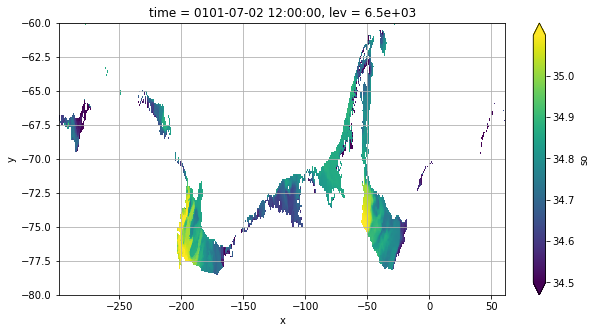

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
sab_t0.where(ds.wet==1).plot(ax=ax,x='x',y='y',robust=True)
ax.set_ylim([-80, -60])
ax.grid(True)
plt.show()

In [17]:
import sys
sys.path.append('/home/Jan-erik.Tesdal/wmt-inert-tracer/scripts/tools')
from compute import horizontal_mean

In [18]:
sab.time[-1]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(450, 7, 2, 12, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    time     object 0450-07-02 12:00:00
    lev      float64 6.5e+03

In [19]:
sab = sab.sel(time=slice('0411',None))

In [20]:
with ProgressBar():
    sab_so = horizontal_mean(sab.where(sab_obs.notnull()),ds).load()

[########################################] | 100% Completed |  2min 22.1s


In [21]:
sab_so

<xarray.DataArray (time: 40)>
array([34.784162  , 34.78043266, 34.77928243, 34.77714389, 34.78346678,
       34.78404528, 34.78017455, 34.77608732, 34.7759023 , 34.76801645,
       34.7568981 , 34.75966715, 34.76646761, 34.77999625, 34.78562298,
       34.78462542, 34.77480453, 34.76446877, 34.76760681, 34.78058499,
       34.78679303, 34.79296643, 34.79147229, 34.79573357, 34.79496713,
       34.79038865, 34.79280291, 34.79281327, 34.79536747, 34.78339856,
       34.77799862, 34.78015452, 34.78740988, 34.79841629, 34.81627901,
       34.81633981, 34.81368053, 34.81305645, 34.81263422, 34.81462883])
Coordinates:
  * time     (time) object 0411-07-02 12:00:00 ... 0450-07-02 12:00:00
    lev      float64 6.5e+03

In [22]:
xr.concat([xr.open_dataset(outdir+'CM4_piControl_c192_OM4p125_v8_0101to0410_sab_onshlf.nc').bottom_sa,sab_so],dim='time')

<xarray.DataArray 'bottom_sa' (time: 350)>
array([34.78274353, 34.78957578, 34.79076212, 34.79319033, 34.79255513,
       34.7930245 , 34.78936349, 34.78818035, 34.7854256 , 34.79147228,
       34.78669328, 34.7874382 , 34.79105541, 34.79269959, 34.79099838,
       34.78781077, 34.76421185, 34.75617935, 34.75643969, 34.76464673,
       34.77033487, 34.7831148 , 34.79326428, 34.78742722, 34.78293469,
       34.7801053 , 34.77148541, 34.77155044, 34.77885291, 34.78473228,
       34.78716056, 34.78993002, 34.7876546 , 34.78284385, 34.77779811,
       34.76169479, 34.75143327, 34.74871205, 34.75695394, 34.76337495,
       34.76895489, 34.77162659, 34.77928045, 34.7806721 , 34.78431813,
       34.78877598, 34.79027756, 34.78599758, 34.78202713, 34.78057376,
       34.78339121, 34.78451725, 34.78202853, 34.78536525, 34.78820028,
       34.78605414, 34.78394892, 34.78705038, 34.78152902, 34.78772175,
       34.78977787, 34.77492079, 34.75871063, 34.75682105, 34.76813453,
       34.78382406, 34.80472169, 34.8132876 , 34.82219725, 34.81747774,
       34.82007799, 34.8234421 , 34.8125615 , 34.80181326, 34.78568379,
       34.77561657, 34.77471312, 34.77129569, 34.76706265, 34.77086051,
       34.78644536, 34.79156649, 34.79704646, 34.7839725 , 34.77733911,
       34.78343665, 34.79407906, 34.79585031, 34.79838933, 34.79753235,
       34.79749751, 34.79561704, 34.79019196, 34.7826688 , 34.78813659,
       34.79939217, 34.80149315, 34.79946082, 34.79317574, 34.78189076,
...
       34.81755174, 34.80964545, 34.80313385, 34.7961387 , 34.78838057,
       34.77653918, 34.77335371, 34.77729175, 34.78260974, 34.78296667,
       34.78843248, 34.79339466, 34.79840166, 34.80491836, 34.81150245,
       34.81811813, 34.81503099, 34.80905884, 34.80243072, 34.79137889,
       34.77815056, 34.76938767, 34.7691713 , 34.77413294, 34.78570769,
       34.79214982, 34.79689621, 34.79469603, 34.79052512, 34.78522634,
       34.79294618, 34.8016233 , 34.80255826, 34.80829278, 34.81891648,
       34.818588  , 34.81354745, 34.80298431, 34.80540111, 34.80235459,
       34.80192902, 34.79569626, 34.78712757, 34.78732952, 34.78709034,
       34.79520338, 34.80380759, 34.81143094, 34.82079855, 34.82215349,
       34.81467172, 34.80943185, 34.80947319, 34.79965055, 34.78166308,
       34.77641254, 34.79342212, 34.80727222, 34.80584466, 34.79669511,
       34.784162  , 34.78043266, 34.77928243, 34.77714389, 34.78346678,
       34.78404528, 34.78017455, 34.77608732, 34.7759023 , 34.76801645,
       34.7568981 , 34.75966715, 34.76646761, 34.77999625, 34.78562298,
       34.78462542, 34.77480453, 34.76446877, 34.76760681, 34.78058499,
       34.78679303, 34.79296643, 34.79147229, 34.79573357, 34.79496713,
       34.79038865, 34.79280291, 34.79281327, 34.79536747, 34.78339856,
       34.77799862, 34.78015452, 34.78740988, 34.79841629, 34.81627901,
       34.81633981, 34.81368053, 34.81305645, 34.81263422, 34.81462883])
Coordinates:
  * time     (time) object 0101-07-02 12:00:00 ... 0450-07-02 12:00:00
    lev      float64 6.5e+03

In [23]:
sab_so = xr.concat([xr.open_dataset(outdir+'CM4_piControl_c192_OM4p125_v8_0101to0410_sab_onshlf.nc').bottom_sa,sab_so],dim='time')

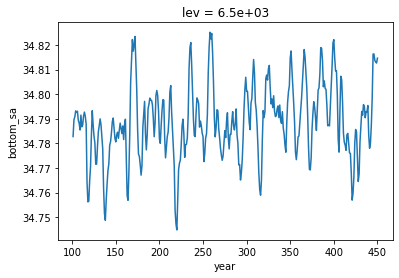

In [24]:
sab_so.groupby('time.year').mean('time').plot()

In [28]:
outdir

'/work/jet/data/interim/'

In [26]:
fname = subdir+'_%sto%s_sab_onshlf.nc'%(str(sab_so.time.dt.year[0].values).rjust(4, '0'),str(sab_so.time.dt.year[-1].values).rjust(4, '0'))
print('Saving to file:', fname)
sab_so.reset_coords(drop=True).to_dataset(name='bottom_sa').to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: CM4_piControl_c192_OM4p125_v8_0101to0450_sab_onshlf.nc


### Plot

In [ ]:
sab_CM4Xp125 = xr.open_dataset(outdir+'CM4_piControl_c192_OM4p125_v7_0001to0350_sab_onshlf.nc').bottom_sa
sab_CM4Xp25 = xr.open_dataset(outdir+'CM4_piControl_c192_OM4p25_v7_0001to0350_sab_onshlf.nc').bottom_sa

In [13]:
101+1748

1849

In [14]:
from datetime import timedelta

In [15]:
# year 101 becomes 1849
sab_CM4Xp125['time'] = sab_CM4Xp125.time + timedelta(days=365*1748)
sab_CM4Xp25['time'] = sab_CM4Xp25.time + timedelta(days=365*1748)

In [24]:


fnameb = 'OM4p25_JRA55do1.4_0netfw_cycle6_extradiags_v3_1958to2017_sab_onshlf.nc'
fnamec = 'OM4p25_CORE_1708to2007_sab_onshlf.nc'
fnamed = 'OM4p5_CORE_1708to2007_sab_onshlf.nc'

ddict = {}

ddict[fnameb] = xr.open_dataset(outdir+fnameb).bottom_sa
ddict[fnamec] = xr.open_dataset(outdir+fnamec).bottom_sa
ddict[fnamed] = xr.open_dataset(outdir+fnamed).bottom_sa

fnamep125 = 'CM4_historical_c192_OM4p125_1850to2014_sab_onshlf.nc'
fnamep25 = 'CM4_historical_c192_OM4p25_1850to2009_sab_onshlf.nc'


ddict[fnamep125] = xr.open_dataset(outdir+fnamep125).bottom_sa
ddict[fnamep25] = xr.open_dataset(outdir+fnamep25).bottom_sa

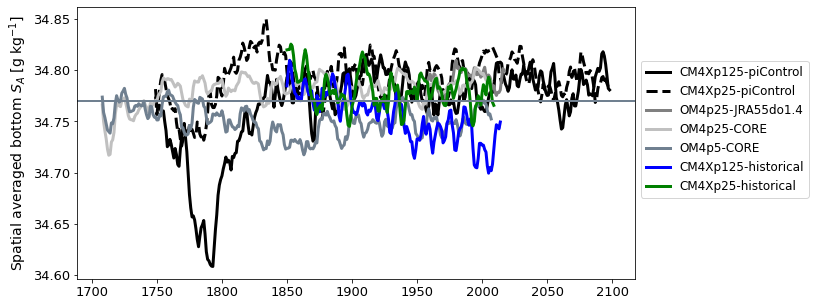

In [27]:
cstr = ['grey','silver','slategrey','blue','green']
labels = ['','','','CM4Xp125-historical','CM4Xp25-historical']
fig, ax = plt.subplots(figsize=(10,5))


sab_CM4Xp125.groupby('time.year').mean('time').plot(ax=ax,lw=3,c='k',_labels=False,
                                               label='CM4Xp125-piControl')
sab_CM4Xp25.groupby('time.year').mean('time').plot(ax=ax,lw=3,c='k',ls='--',_labels=False,
                                               label='CM4Xp25-piControl')

for i, s in enumerate(ddict):
    labl = labels[i] if s.split('_')[0]=='CM4' else s.split('_')[0]+'-'+s.split('_')[1]
    #print(labl)
    sss_so = ddict[s]
    sss_so.groupby('time.year').mean('time').plot(ax=ax,lw=3,c=cstr[i],_labels=False,label=labl)
    
ax.axhline(y=34.77, xmin=0, xmax=1, c = 'slategrey', lw=2.0, ls='-')
#ax.legend(frameon=True, fancybox=True,loc='lower left', ncol=1, fontsize=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.55), frameon=True, fancybox=True, ncol=1, fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_ylabel('Spatial averaged bottom $S_{A}$ [g kg$^{-1}$]',fontsize=14)
plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

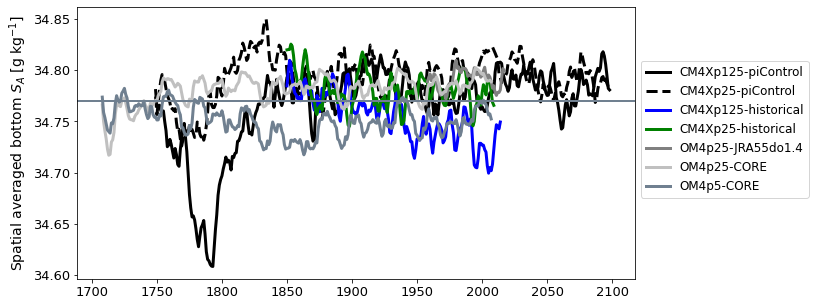

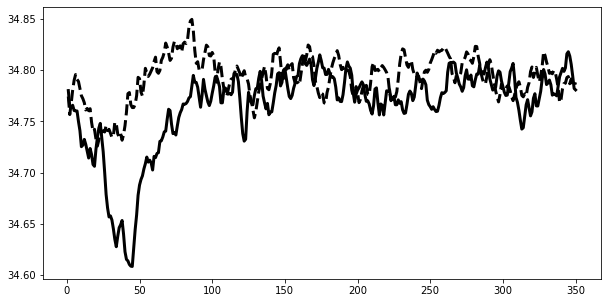

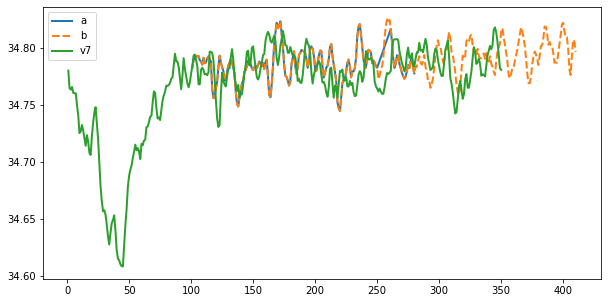

In [27]:
fnamev7 = 'CM4_piControl_c192_OM4p125_v7_0001to0350_sab_onshlf.nc'
fnamea = 'CM4_piControl_c192_OM4p125_v8_0101to0280_sab_onshlf.nc'
fnameb = 'CM4_piControl_c192_OM4p125_v8_0101to0410_sab_onshlf.nc'
ddict = {s:{} for s in ['a','b']}

ddict['a'] = xr.open_dataset(outdir+fnamea).bottom_sa
ddict['b'] = xr.open_dataset(outdir+fnameb).bottom_sa
ddict['v7'] = xr.open_dataset(outdir+fnamev7).bottom_sa


fig, ax = plt.subplots(figsize=(10,5))
for i, s in enumerate(ddict):
    sss_so = ddict[s]
    sss_so.groupby('time.year').mean('time').plot(ax=ax,lw=3 if s=='old' else 2,ls='--' if i==1 else '-',
                                                  _labels=False,label=s)
ax.legend()
plt.show()

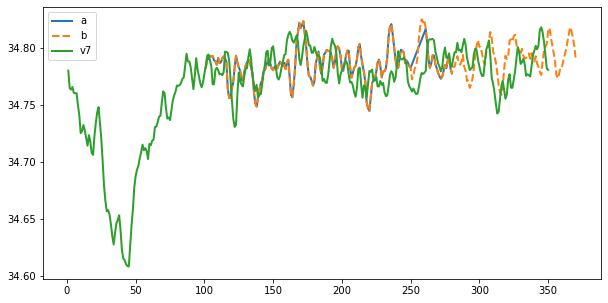

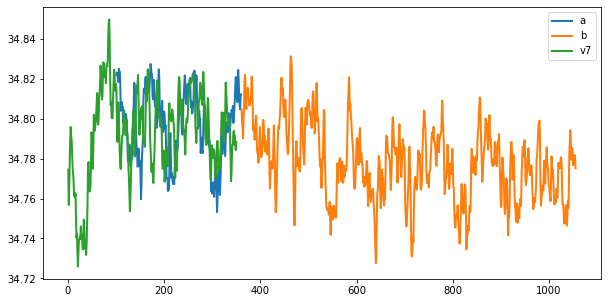

In [31]:
fnamev7 = 'CM4_piControl_c192_OM4p25_v7_0001to0350_sab_onshlf.nc'
fnamea = 'CM4_piControl_c192_OM4p25_v8_0101to0360_sab_onshlf.nc'
fnameb = 'CM4_piControl_c192_OM4p25_v8_0361to1055_sab_onshlf.nc'
ddict = {s:{} for s in ['a','b']}

ddict['a'] = xr.open_dataset(outdir+fnamea).bottom_sa
ddict['b'] = xr.open_dataset(outdir+fnameb).bottom_sa
ddict['v7'] = xr.open_dataset(outdir+fnamev7).bottom_sa


fig, ax = plt.subplots(figsize=(10,5))
for i, s in enumerate(ddict):
    sss_so = ddict[s]
    sss_so.groupby('time.year').mean('time').plot(ax=ax,lw=3 if s=='old' else 2,_labels=False,label=s)
ax.legend()
plt.show()

In [24]:
fname_old = 'CM4_historical_c192_OM4p125_1850to2009_sab_onshlf.nc'
fname_new = 'CM4_historical_c192_OM4p125_1850to2014_sab_onshlf.nc'
ddict = {s:{} for s in ['old','new']}
ddict['old'] = xr.open_dataset(outdir+fname_old).bottom_sa
ddict['new'] = xr.open_dataset(outdir+fname_new).bottom_sa

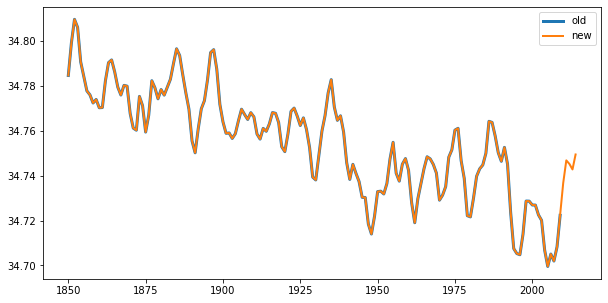

In [25]:
fig, ax = plt.subplots(figsize=(10,5))
for i, s in enumerate(ddict):
    sss_so = ddict[s]
    sss_so.groupby('time.year').mean('time').plot(ax=ax,lw=3 if s=='old' else 2,_labels=False,label=s)
ax.legend()
plt.show()

In [27]:
fname_odiv1 = 'CM4_piControl_C_0001to0650_sab_onshlf.nc'
#fname_odiv191 = 'CM4_piControl_c192_OM4p125_v6_0001to0040_sss_onshlf.nc'
#fname_odiv200 = 'CM4_piControl_c192_OM4p125_v6_alt1_0001to0200_sab_onshlf.nc'
#fname_odiv206 = 'CM4_piControl_c192_OM4p125_v6_alt2_0181to0200_sab_onshlf.nc'
#fname_odiv207 = 'CM4_piControl_c192_OM4p125_v6_alt3_0181to0200_sab_onshlf.nc'
fname_odiv209 = 'CM4_piControl_c192_OM4p125_v7_0001to0350_sab_onshlf.nc'
fname_odiv210 = 'CM4_piControl_c192_OM4p25_v7_0001to0350_sab_onshlf.nc'
fname_odiv226 = 'CM4_piControl_c192_OM4p25_v7_npolefix_0251to0350_sab_onshlf.nc'

ddict = {s:{} for s in ['Odiv-1','Odiv-209','Odiv-210','Odiv-226']}
ddict['Odiv-1'] = xr.open_dataset(outdir+fname_odiv1).bottom_sa
#ddict['Odiv-200'] = xr.open_dataset(outdir+fname_odiv200).bottom_sa
#ddict['Odiv-206'] = xr.open_dataset(outdir+fname_odiv206).bottom_sa
#ddict['Odiv-207'] = xr.open_dataset(outdir+fname_odiv207).bottom_sa
ddict['Odiv-209'] = xr.open_dataset(outdir+fname_odiv209).bottom_sa
ddict['Odiv-210'] = xr.open_dataset(outdir+fname_odiv210).bottom_sa
ddict['Odiv-226'] = xr.open_dataset(outdir+fname_odiv226).bottom_sa

#ddict['ESM4'] = xr.open_dataset(outdir+'ESM4_piControl_0001to1100_sab_onshlf.nc').bottom_sa

In [28]:
sab_so_jra = xr.open_dataset(outdir+'OM4p25_JRA55do1.4_0netfw_cycle6_extradiags_v3_1958to2017_sab_onshlf.nc').sel(time=slice('1958','2017')).bottom_sa
sab_so_core = xr.open_dataset(outdir+'OM4p25_CORE_1708to2007_sab_onshlf.nc').sel(time=slice('1958','2007')).bottom_sa

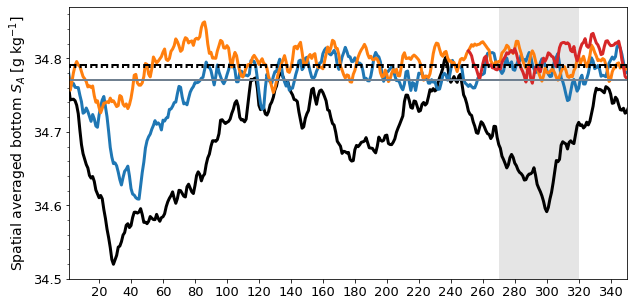

In [29]:
cstr = ['k','tab:blue','tab:orange','tab:red']

fig, ax = plt.subplots(figsize=(10,5))

for i, s in enumerate(ddict):
    
    sss_so = ddict[s]
    sss_so.groupby('time.year').mean('time').plot(ax=ax,lw=3 if s in ['Odiv-1','Odiv-200'] else 3,c=cstr[i],_labels=False,label=s)
    
#ax.axhline(y=sss_so_jra.mean('time'), xmin=0, xmax=1, c = 'k', lw=2.0, ls='--')
#ax.axhline(y=sss_so_core.mean('time'), xmin=0, xmax=1, c = 'k', lw=2.0, ls=':')
ax.axhline(y=34.77, xmin=0, xmax=1, c = 'slategrey', lw=2.0, ls='-')
ax.axhline(y=sab_so_jra.mean('time'), xmin=0, xmax=1, c = 'k', lw=2.0, ls='--')
ax.axhline(y=sab_so_core.mean('time'), xmin=0, xmax=1, c = 'k', lw=2.0, ls=':')

ylimit = ax.get_ylim()
#ax.fill([226,235,235,226],[ylimit[0]-1,ylimit[0]-1,ylimit[1]+0.2,ylimit[1]+0.2],'y', alpha=0.2, edgecolor='None')
ax.fill([270,320,320,270],[ylimit[0],ylimit[0],ylimit[1]+0.2,ylimit[1]+0.2],'grey', alpha=0.2, edgecolor='None')
#ax.fill([250,270,270,250],[ylimit[0]-1,ylimit[0]-1,ylimit[1]+0.2,ylimit[1]+0.2],'purple', alpha=0.2, edgecolor='None')

ax.set_xlim([1, 350])
ax.set_xticks(np.arange(20,360,20), minor=False)
#ax.legend(frameon=True, fancybox=True,loc='upper left', ncol=3, fontsize=12)
ax.set_yticks(np.arange(34.5,34.9,0.1))
ax.set_yticks(np.arange(34.5,34.87,0.02), minor=True)
ax.set_ylim([34.5, 34.87])

ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_ylabel('Spatial averaged bottom $S_{A}$ [g kg$^{-1}$]',fontsize=14)
#ax.text(200, sab_so_jra.mean('time'), 'OM4p25-JRA55 mean (1958-2017)', ha='right', va='bottom', fontsize=12, fontweight='bold')
#ax.text(1, sab_so_core.mean('time'), 'OM4p25-CORE mean (1958-2007)', ha='left', va='top', fontsize=12, fontweight='bold')

#plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
#            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

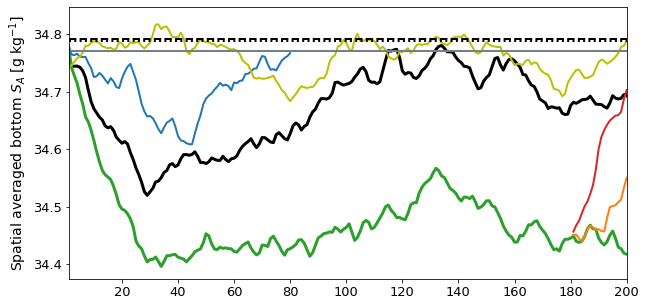